<a href="https://colab.research.google.com/github/JosiahLC/games-sales-rating/blob/main/rating_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
%%capture
!pip install category_encoders==2.*
!pip install shap
!pip install pdpbox
!pip install xgboost
import numpy as np
import pandas as pd

from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from category_encoders import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
import shap
from xgboost import XGBRegressor
from matplotlib import pyplot as plt
from pdpbox.pdp import pdp_isolate, pdp_plot, pdp_interact, pdp_interact_plot

In [7]:
pip install matplotlib --force-reinstall --user

  Using cached matplotlib-3.4.3-cp37-cp37m-manylinux1_x86_64.whl (10.3 MB)
  Using cached python_dateutil-2.8.2-py2.py3-none-any.whl (247 kB)
  Using cached pyparsing-2.4.7-py2.py3-none-any.whl (67 kB)
  Using cached kiwisolver-1.3.2-cp37-cp37m-manylinux_2_5_x86_64.manylinux1_x86_64.whl (1.1 MB)
  Using cached cycler-0.10.0-py2.py3-none-any.whl (6.5 kB)
  Using cached numpy-1.21.2-cp37-cp37m-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (15.7 MB)
  Using cached Pillow-8.3.1-cp37-cp37m-manylinux_2_5_x86_64.manylinux1_x86_64.whl (3.0 MB)
  Using cached six-1.16.0-py2.py3-none-any.whl (11 kB)
  Attempting uninstall: six
    Found existing installation: six 1.16.0
    Uninstalling six-1.16.0:
      Successfully uninstalled six-1.16.0
  Attempting uninstall: python-dateutil
    Found existing installation: python-dateutil 2.8.2
    Uninstalling python-dateutil-2.8.2:
      Successfully uninstalled python-dateutil-2.8.2
  Attempting uninstall: pyparsing
    Found existing installation: pypa

In [8]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report, roc_auc_score
from category_encoders import OneHotEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

In [9]:
pd.options.display.max_rows = 200

In [10]:

df = pd.read_csv('vgsales.csv',parse_dates=['Year_of_Release'],index_col='Year_of_Release')
df = df.sort_index(ascending=False)
df.head()

,Name,Platform,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating
Year_of_Release,,,,,,,,,,,,,,,
2020-01-01,Imagine: Makeup Artist,DS,Simulation,Ubisoft,0.27,0.0,0.00,0.02,0.29,NaN,NaN,tbd,NaN,Ubisoft,E
2017-01-01,Phantasy Star Online 2 Episode 4: Deluxe Package,PS4,Role-Playing,Sega,0.00,0.0,0.04,0.00,0.04,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-01,Brothers Conflict: Precious Baby,PSV,Action,Idea Factory,0.00,0.0,0.01,0.00,0.01,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-01,Phantasy Star Online 2 Episode 4: Deluxe Package,PSV,Role-Playing,Sega,0.00,0.0,0.01,0.00,0.01,NaN,NaN,NaN,NaN,NaN,NaN
2016-01-01,Winning Post 8 2016,PSV,Simulation,Tecmo Koei,0.00,0.0,0.01,0.00,0.01,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
df['Developer'].value_counts()

Ubisoft                       204
EA Sports                     172
EA Canada                     167
Konami                        162
Capcom                        139
                             ... 
BioWare, Demiurge Studios       1
Pax Softonica                   1
ApolloSoft                      1
Foundation 9 Entertainment      1
Deep Red                        1
Name: Developer, Length: 1696, dtype: int64

In [12]:
dev = df['Developer'].value_counts()[df['Developer'].value_counts()>100].index.tolist()
pub = df['Publisher'].value_counts()[df['Publisher'].value_counts()>100].index.tolist()
plat = df['Platform'].value_counts()[df['Platform'].value_counts()>90].index.tolist()

In [13]:
df['dev']=np.where(df['Developer'].isin(dev),df['Developer'],'few developments')
df['pub']=np.where(df['Publisher'].isin(pub),df['Publisher'],'few publishments')
df['plat']=np.where(df['Platform'].isin(plat),df['Platform'],'small platform')
df.drop(columns=['Publisher','Developer','Platform'],inplace=True)

In [14]:
target = 'Rating'
Xn = df.drop(columns=['NA_Sales', 'EU_Sales','JP_Sales','Other_Sales', target,'Name'])
y=df[target]
#Regression problem
#skewed look at a log dist
#i will consider meanabserror rootmean and r^2
#date cutoff split
#i have removed NA,EU,JP,and other sales, and may use those as targets to futher evaluate the data
#the name, and developer column has been removed because of HCC

In [15]:
y.fillna('NR/na',inplace=True)
Xn['Genre'].fillna('NR/na',inplace=True)
Xn['User_Score'] = pd.to_numeric(Xn['User_Score'],errors='coerce')

Xn.fillna(0,inplace=True)
Xn.isnull().sum()
y.isnull().sum()

0

In [16]:
ohe = OneHotEncoder(use_cat_names=True)
ohe.fit(Xn)
X = ohe.transform(Xn)

In [17]:
#X_train, X_val, y_train, y_val = train_test_split(X,y, test_size=0.2, random_state = 42)
X_train,y_train = X[:'2010-01-01'],y[:'2010-01-01']
X_val,y_val = X['2010-01-01':],y['2010-01-01':]

In [18]:
print('The baseline accuracy is ', y_train.value_counts(normalize=True).max())

The baseline accuracy is  0.40003219575016097


In [19]:
X_train.columns

Index(['Genre_Simulation', 'Genre_Role-Playing', 'Genre_Action',
       'Genre_Shooter', 'Genre_Sports', 'Genre_Misc', 'Genre_Adventure',
       'Genre_Strategy', 'Genre_Racing', 'Genre_Fighting', 'Genre_Platform',
       'Genre_Puzzle', 'Genre_NR/na', 'Global_Sales', 'Critic_Score',
       'Critic_Count', 'User_Score', 'User_Count', 'dev_Ubisoft',
       'dev_few developments', 'dev_EA Sports', 'dev_Konami',
       'dev_Ubisoft Montreal', 'dev_Capcom', 'dev_EA Tiburon', 'dev_EA Canada',
       'dev_Electronic Arts', 'pub_Ubisoft', 'pub_Sega', 'pub_Idea Factory',
       'pub_Tecmo Koei', 'pub_few publishments', 'pub_Electronic Arts',
       'pub_Square Enix', 'pub_Capcom', 'pub_Konami Digital Entertainment',
       'pub_Activision', 'pub_505 Games', 'pub_Unknown',
       'pub_Sony Computer Entertainment', 'pub_Nippon Ichi Software',
       'pub_Namco Bandai Games', 'pub_Nintendo', 'pub_Atari',
       'pub_D3Publisher', 'pub_Take-Two Interactive',
       'pub_Warner Bros. Interactive En

In [20]:
LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

In [21]:
model_lr = LogisticRegression().fit(X_train,y_train)
model_rf = RandomForestClassifier().fit(X_train,y_train)
model_dc = DecisionTreeClassifier().fit(X_train,y_train)
model_xgbc = XGBClassifier().fit(X_train,y_train)



In [22]:
y.value_counts(normalize=True)

NR/na    0.404869
E        0.238710
T        0.177104
M        0.093486
E10+     0.084933
EC       0.000478
RP       0.000179
K-A      0.000179
AO       0.000060
Name: Rating, dtype: float64

In [23]:
def check_metrics(model):
  print(model)
  print('Validation Accuracy', model.score(X_val, y_val))

model = [model_lr,model_rf,model_dc,model_xgbc]
for m in model:
  check_metrics(m)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
Validation Accuracy 0.6624123532655795
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
Validation Accuracy 0.9776254628535413
DecisionTreeClassifier(ccp_alpha=0.0, class_weigh

In [24]:
model_rfp = make_pipeline( OrdinalEncoder(),
                         SimpleImputer(strategy = 'mean'),
                         RandomForestClassifier(n_jobs = -1, random_state=42, n_estimators=75))
model_rfp.fit(X_train,y_train)

Pipeline(memory=None,
         steps=[('ordinalencoder',
                 OrdinalEncoder(cols=[], drop_invariant=False,
                                handle_missing='value', handle_unknown='value',
                                mapping=[], return_df=True, verbose=0)),
                ('simpleimputer',
                 SimpleImputer(add_indicator=False, copy=True, fill_value=None,
                               missing_values=nan, strategy='mean',
                               verbose=0)),
                ('randomforestclassifier',
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=None, max_features='auto',
                                        max_leaf_nodes=None, max_samples=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                      

In [25]:
X.columns

Index(['Genre_Simulation', 'Genre_Role-Playing', 'Genre_Action',
       'Genre_Shooter', 'Genre_Sports', 'Genre_Misc', 'Genre_Adventure',
       'Genre_Strategy', 'Genre_Racing', 'Genre_Fighting', 'Genre_Platform',
       'Genre_Puzzle', 'Genre_NR/na', 'Global_Sales', 'Critic_Score',
       'Critic_Count', 'User_Score', 'User_Count', 'dev_Ubisoft',
       'dev_few developments', 'dev_EA Sports', 'dev_Konami',
       'dev_Ubisoft Montreal', 'dev_Capcom', 'dev_EA Tiburon', 'dev_EA Canada',
       'dev_Electronic Arts', 'pub_Ubisoft', 'pub_Sega', 'pub_Idea Factory',
       'pub_Tecmo Koei', 'pub_few publishments', 'pub_Electronic Arts',
       'pub_Square Enix', 'pub_Capcom', 'pub_Konami Digital Entertainment',
       'pub_Activision', 'pub_505 Games', 'pub_Unknown',
       'pub_Sony Computer Entertainment', 'pub_Nippon Ichi Software',
       'pub_Namco Bandai Games', 'pub_Nintendo', 'pub_Atari',
       'pub_D3Publisher', 'pub_Take-Two Interactive',
       'pub_Warner Bros. Interactive En

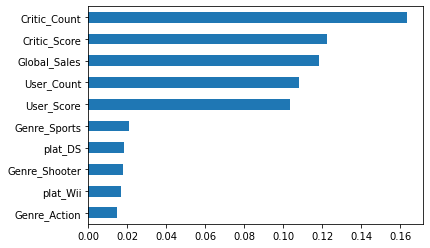

In [43]:
importances =  model_rfp.named_steps['randomforestclassifier'].feature_importances_
feature_names = X_train.columns
feat_imp =pd.Series(data=importances,index=feature_names).sort_values(key=abs)
feat_imp.tail(10).plot(kind='barh')

In [42]:
feat_imp.tail(7)

plat_DS         0.018345
Genre_Sports    0.020775
User_Score      0.103556
User_Count      0.107892
Global_Sales    0.118065
Critic_Score    0.122184
Critic_Count    0.163374
dtype: float64

In [27]:
print(X_val.shape)
print(X_train.shape)

(12693, 80)
(12424, 80)


(<Figure size 1080x2304 with 17 Axes>,
 {'pdp_inter_ax': [<matplotlib.axes._subplots.AxesSubplot at 0x7fad67aea390>,
  'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7fad6a3b71d0>})

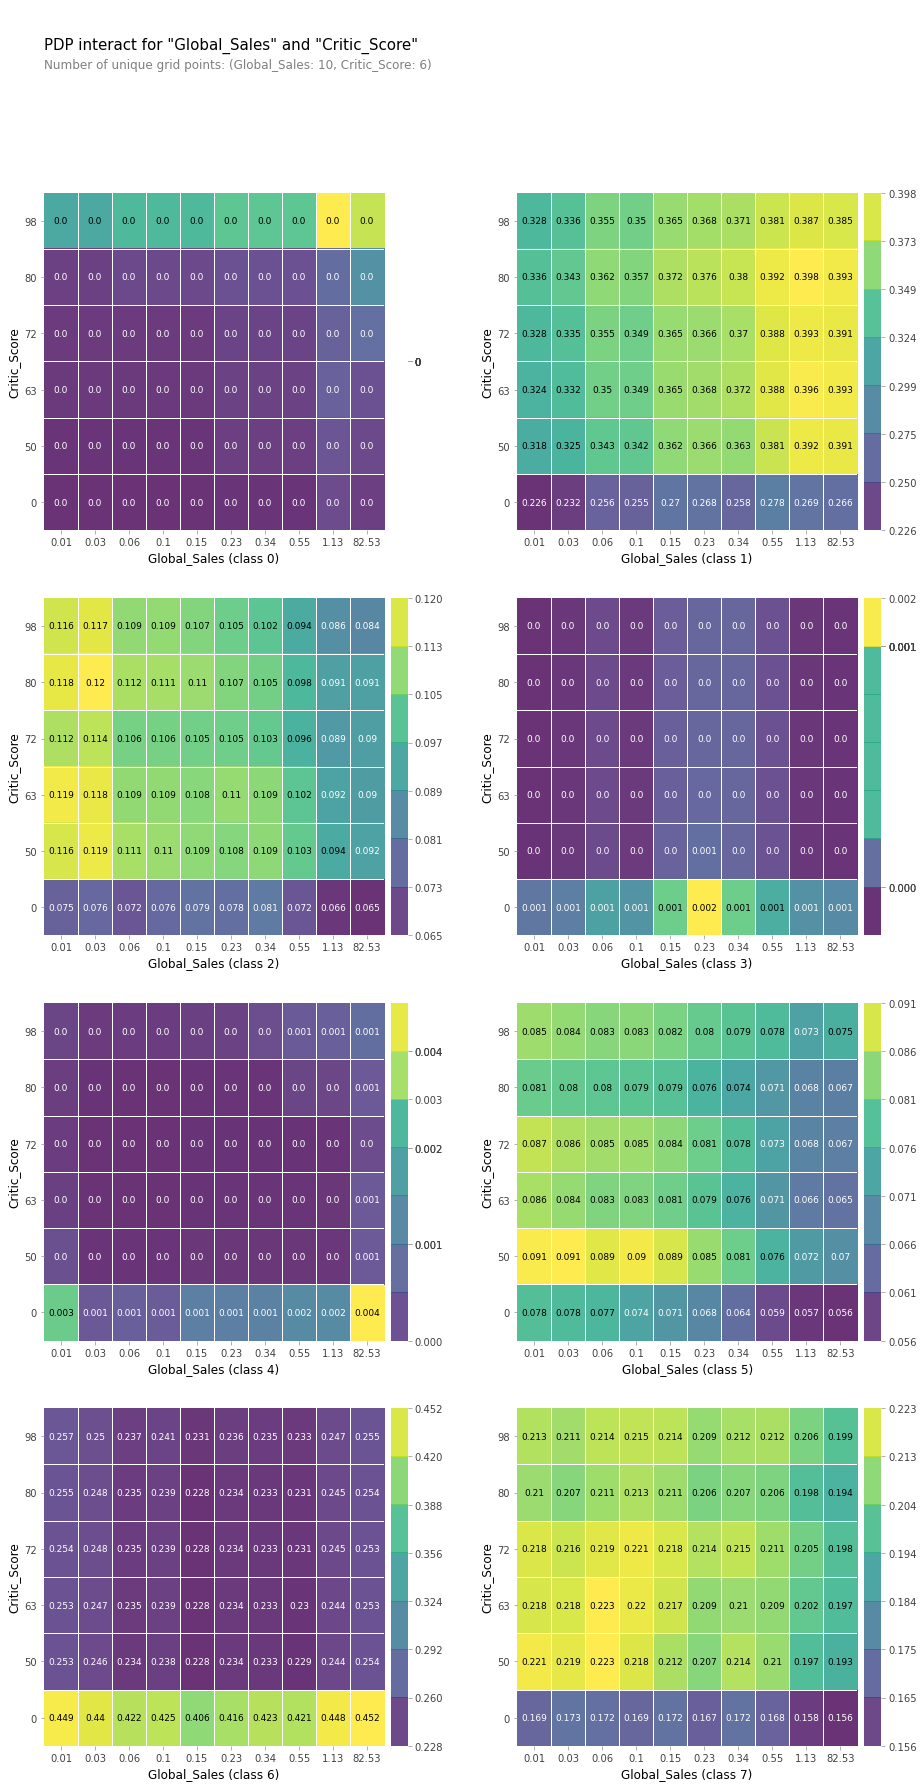

In [44]:
features = ['Global_Sales','Critic_Score']
interact = pdp_interact(model_rfp, dataset=X_val,
                        model_features = X_val.columns,
                        features = features)
pdp_interact_plot(interact,plot_type = 'grid',feature_names = features)

In [31]:
print(X_val.shape)
print(X_train.shape)

(12693, 80)
(12424, 80)
